In [1]:
import os
import pandas as pd

from itkwidgets import view  ## for jupyter notebook
import numpy as np
from scipy import stats
from scipy.odr import *

import matplotlib.pyplot as plt

from pandas.plotting import parallel_coordinates
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import manifold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

import altair as alt



Constructing df from csv imports

In [2]:
import_dir = r'C:\Users\Winnie\Desktop\QCB\Drug datasets export'

df = pd.read_csv(os.path.join(import_dir, 'df.csv'), header = 0)
ds_gol_fea = pd.read_csv(os.path.join(import_dir, 'ds_gol_fea.csv'), 
                         header = 0)
ds_tub_fea = pd.read_csv(os.path.join(import_dir, 'ds_tub_fea.csv'), 
                         header = 0)
ds_sec_fea = pd.read_csv(os.path.join(import_dir, 'ds_sec_fea.csv'), 
                         header = 0)
ds_dna_fea = pd.read_csv(os.path.join(import_dir, 'ds_dna_fea.csv'), 
                         header = 0)
ds_mem_fea = pd.read_csv(os.path.join(import_dir, 'ds_mem_fea.csv'), 
                         header = 0)


## Global Variables

In [3]:
    
STRUCTURE = 'golgi'
NOM_COLS = ['drug_label', 'cell_id', 'cell_ver', 'czi_filename', 
            'idx_in_stack', 'roi', 'str_ver', 'structure_name']

## Features of interest
STRUC_FEA_DIC = {'golgi': list(ds_gol_fea),
                 'tubulin': list(ds_tub_fea),
                 'sec61b': list(ds_sec_fea)}

DNA_FOI = list(ds_dna_fea)
DNA_FOI.remove('cell_id')

MEM_FOI = list(ds_mem_fea)
MEM_FOI.remove('cell_id')

STRUC_FOI = STRUC_FEA_DIC.get(STRUCTURE)
STRUC_FOI.remove('cell_id')

ALL_FOI = DNA_FOI + MEM_FOI + STRUC_FOI

## Which FOI list to use
FOI = ALL_FOI

## Creating Subsets, Prepping Dataframes for Plotting

In [4]:

# Make subsets, color mapping

struc_subset = df.groupby(by='structure_name').get_group(STRUCTURE)
## Save out nominal columns
nom_cols = struc_subset[NOM_COLS]

## fill struc_subset with DNA, MEM, and STR features
struc_subset = struc_subset[ALL_FOI]

## get color mapping of drug to color
## Change the drug_label column to category dtypes and change to codes
struc_subset['drug_label'] = nom_cols['drug_label']
struc_subset['drug_label'] = struc_subset['drug_label'].astype("category")
mapping = dict(enumerate(struc_subset['drug_label'].cat.categories))
mapping = list(mapping.values())
color_map = ['b', 'g', 'k', 'y', 'r', 'm', 'c']

## Add column for scene number
scene_number = []
session_number = []
for filename in nom_cols['czi_filename']:
    before, after = filename.split('-Scene-')
    scene = after.split('-')[0]
    session = before.split('_')[-1]
    scene_number.append(scene)
    session_number.append(session)
    
struc_subset['scene_number'] = scene_number
struc_subset['session_number'] = session_number
struc_subset['scene_number'] = struc_subset['scene_number'].astype('int64')
struc_subset['session_number'] = struc_subset['session_number'].astype('int64')

## assign color per drug
color_selection = [color_map[index] for index in range(len(mapping))]

In [5]:
## golgi
foi = ['str_1st_axis_length_mean',
        'str_2nd_axis_length_mean',
        'str_3rd_axis_length_mean',
        'str_equator_eccentricity_mean',
        'str_meridional_eccentricity_mean',
        'str_number_of_components',
        'str_sphericity_mean',
        'str_surface_area_mean',
        'str_volume_mean']

## Dictionary of feature grouping
d = {'DNA Features': DNA_FOI, 
     'MEM Features': MEM_FOI,
     'DNA and MEM Features': DNA_FOI + MEM_FOI,
     'Structure Features': STRUC_FOI,
     'All Features': ALL_FOI,
     'Selected Structure Features': foi}




In [6]:
## plot_order - select which drug groups to plot
plot_order = ['Vehicle']
for i in range(len(mapping)):
    if mapping[i] not in plot_order:
        plot_order.append(mapping[i])  

In [7]:
## Formatting df to run before PCA/ISOMAP/LDA

## Turn NaN values into 0's (with number of structure components = 0 and 1)
struc_subset_filled = struc_subset[ALL_FOI]
struc_subset_filled = struc_subset_filled.fillna(0, inplace=False)
#struc_subset_filled = struc_subset

## Add drug_label column - LDA will ignore this column
struc_subset_filled['drug_label'] = nom_cols['drug_label']
struc_subset_filled['session_number'] = struc_subset['session_number']
struc_subset_filled['cell_id'] = nom_cols['cell_id']
struc_subset_filled['czi_filename'] = nom_cols['czi_filename']


# Altair Interactive Plots

## Plotting Structure Volume Mean, Sum, and number of pieces against dna volume

In [11]:
## data with DNA, MEM, and STRUCTURE features + 'drug_label' + 'session_number'
data = struc_subset_filled

## selection types has interval, single, and multi
#brush = alt.selection(type='interval', resolve='global')

def Altairplot(data, drug, x_lab='dna_volume'):
    brush = alt.selection(type='multi', encodings=['x'])
    
    dff = data.groupby('drug_label').get_group(drug)
    scatterbase = alt.Chart(dff).mark_point().encode(
        x=x_lab,
        color=alt.condition(brush, 'drug_label:N', alt.ColorValue('gray')),
        tooltip=['cell_id:N', 'czi_filename:N', 'session_number:O']
    ).add_selection(
        brush
    ).properties(
        width=300,
        height=300
    ).interactive()
    
    return scatterbase

def scatterbysession(data, drug, x_lab, y_lab, session=None):
    dff = data.groupby('drug_label').get_group(drug)
    
    sessionscatter = alt.Chart(dff).mark_point().encode(
        x=x_lab,
        y=y_lab,
        color='session_number:N',
        tooltip=['cell_id:N', 'czi_filename:N']
    ).properties(
        width=300,
        height=300
    ).interactive()
    
    sessionscatter += linregressplot(data, drug, x_lab, y_lab, session)
        
    return sessionscatter

def linregressplot(data, drug, x_lab, y_lab, session=None):
    dff = data.groupby('drug_label').get_group(drug)
    x = dff[x_lab]
    y = dff[y_lab]
    
    [linregdata, r_sq, slope] = GetLinRegress(x, y)
    
    linregress = alt.Chart(linregdata).mark_line().encode(
    x='x_fit',
    y='y_fit',
    color=alt.value('black')
    ).properties(
        title= f'{drug}, R^2= {r_sq:.3f}, Slope= {slope:.5f}, Session= {session}'
    ).interactive()
    
    return linregress
    
def GetLinRegress(x, y):
    x_norm = x
    y_norm = y
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_norm, y_norm)
    r_sq = r_value**2
    
    ## Linear Regression
    linear_model = Model(linear_f)
                    
    ## Real Data Object             
    data = Data(x, y)

    ## Set up ODR with model and data
    odr = ODR(data, linear_model, beta0=[0, 1])
    odr.set_job(fit_type=0)
    out = odr.run()

    x_fit = x
    y_fit = linear_f(out.beta, x_fit)
    
    linregdata = pd.DataFrame({'x_fit': x_fit,
                        'y_fit': y_fit})
    
    return linregdata, r_sq, slope

## Function to fit data with
def linear_f(p, x):
    m, c = p
    return m*x + c 

## Does structure (number of pieces, volume sum, and volume mean) varies with DNA?

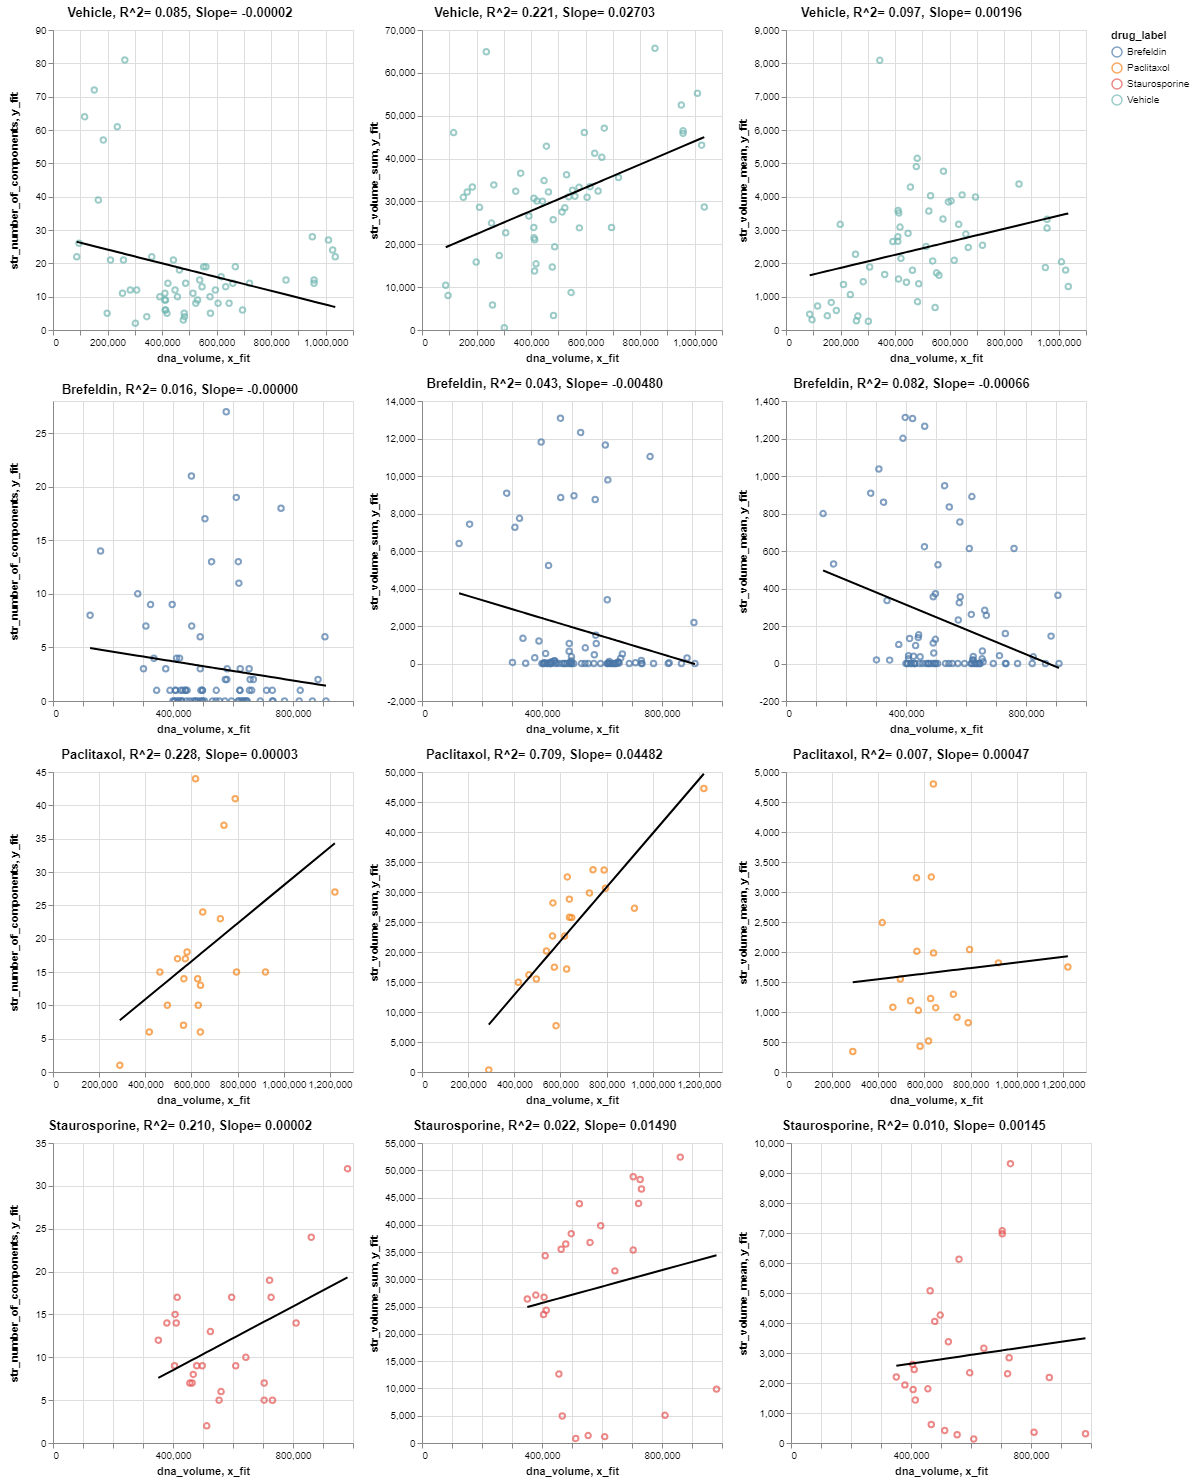

In [9]:
def linregressplot(data, drug, x_lab, y_lab, session=None):
    dff = data.groupby('drug_label').get_group(drug)
    x = dff[x_lab]
    y = dff[y_lab]
    
    [linregdata, r_sq, slope] = GetLinRegress(x, y)
    
    linregress = alt.Chart(linregdata).mark_line().encode(
    x='x_fit',
    y='y_fit',
    color=alt.value('black')
    ).properties(
        title= f'{drug}, R^2= {r_sq:.3f}, Slope= {slope:.5f}'
    ).interactive()
    
    return linregress

drugs = ['Vehicle', 'Brefeldin', 'Paclitaxol', 'Staurosporine']
rows = {}
x_lab = 'dna_volume'
y_labs = ['str_number_of_components', 'str_volume_sum', 'str_volume_mean']

for drug in drugs:
    scatterbase = Altairplot(data, drug, x_lab=x_lab)
    index = drugs.index(drug)
    rows[f'row{index+1}'] = alt.hconcat(*[scatterbase.encode(y=y_lab) + linregressplot(data, drug, x_lab, y_lab) for y_lab in y_labs])

chart = alt.vconcat()
for row, plots in rows.items():
    chart &= plots

chart

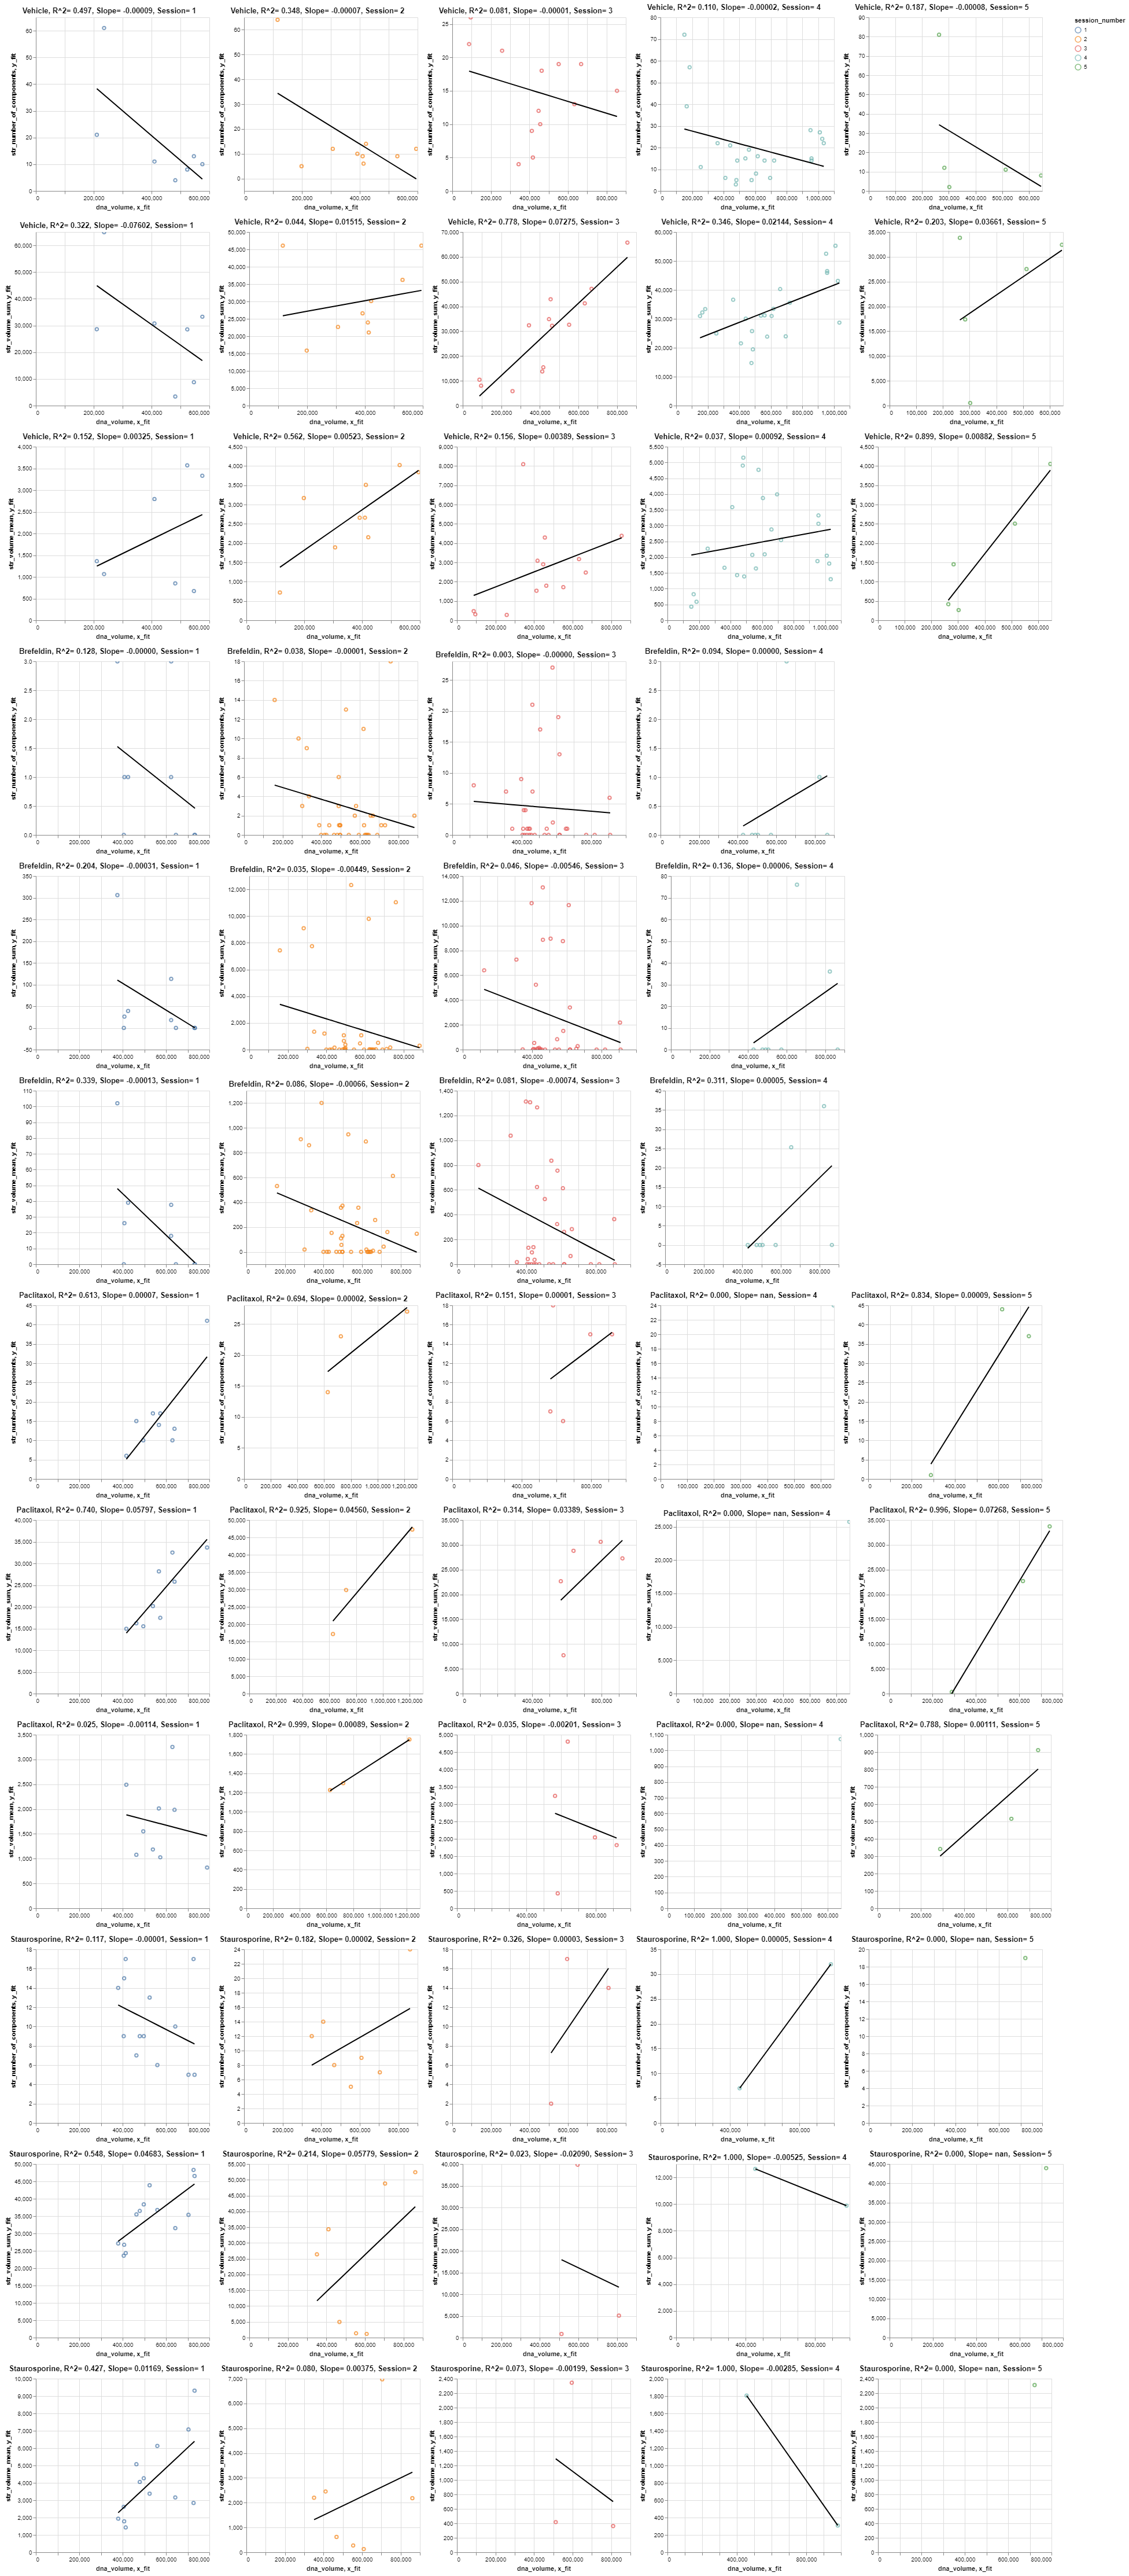

In [12]:

drugs = ['Vehicle', 'Brefeldin', 'Paclitaxol', 'Staurosporine']
x_lab = 'dna_volume'
y_labs = ['str_number_of_components', 'str_volume_sum', 'str_volume_mean']

chart = alt.vconcat()
for drug in drugs:
    drug_group = data.groupby('drug_label').get_group(drug)
    
    drugchart = alt.vconcat()
    for y_lab in y_labs:
        #sessions = list(sorted(set(drug_group['session_number'].unique()))
        sessions = sorted(list(drug_group['session_number'].unique()))
        row = alt.hconcat()
        for session in sessions:
            dff = drug_group.groupby('session_number').get_group(session)
            row |= scatterbysession(dff, drug, x_lab, y_lab, session=session)
        drugchart &= row
    chart &= drugchart
chart